In [1]:
import numpy as np
import scipy.signal
#import pandas as pd
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft, rfftfreq
from pprint import pprint
from scipy.stats import norm

In [2]:
N = 3001
t_step = 0.001

a = 0.05
b = 0.002
c = 2

x_arr = np.arange(N) 
t_arr = x_arr*t_step
in_arr = np.sin(a*x_arr) + 1*np.cos(b*x_arr) 
in_arr += 0.05*np.sin(c*x_arr) #+ 0.05*np.cos(2*c*x_arr) # add some noise

In [3]:
freq_arr = rfftfreq(N, d=t_step)
fft_arr = rfft(in_arr)
fft_abs_arr = np.abs(fft_arr)
ifft_arr = irfft(fft_arr)

In [4]:
print(len(fft_arr))
print(len(x_arr))
print(len(ifft_arr))

1501
3001
3000


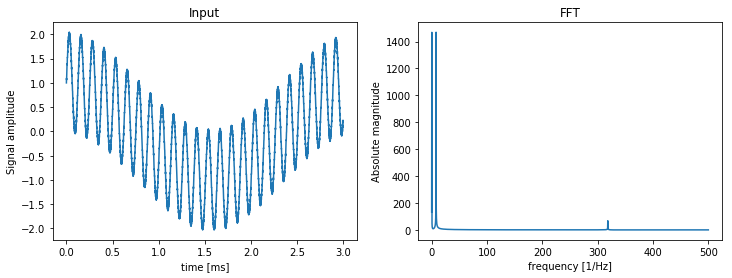

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))

# input
ax[0].plot(t_arr, in_arr)
ax[0].set_title('Input')
ax[0].set_xlabel('time [ms]')
ax[0].set_ylabel('Signal amplitude')

ax[1].plot(freq_arr, fft_abs_arr)
ax[1].set_title('FFT')
ax[1].set_xlabel('frequency [1/Hz]')
ax[1].set_ylabel('Absolute magnitude')

In [6]:
peaks = scipy.signal.find_peaks(fft_abs_arr)[0]
print(freq_arr[peaks])
print(fft_abs_arr[peaks])

[  0.33322226   7.99733422 318.22725758]
[1468.23821804 1469.09938628   68.05968099]


## Example of the padding and noise filtering

In [7]:
N = 500
t_step = 0.001
x_arr = np.arange(N)
t_arr = x_arr*t_step
freq_arr = rfftfreq(N, d=t_step)
noise = np.random.normal(0,0.1,N) # Additive White Gaussian Noise

in_arr = np.ones(N)
in_sine = in_arr + 0.5*np.sin(0.2*x_arr) 
in_sine_exp = in_sine + np.exp(0.1*x_arr)*np.exp(-0.1*(N-7))
in_noisy_sine_exp = in_sine_exp + noise

pad_width = 100
t_arr_padded = np.arange(-pad_width*t_step, (N+pad_width)*t_step, t_step)
freq_arr_padded = rfftfreq(N+2*pad_width, d=t_step)
padded_noisy_sine_exp = np.pad(in_noisy_sine_exp, pad_width, 'symmetric', reflect_type='odd')

In [8]:
fft_arr = rfft(in_arr)
fft_sine = rfft(in_sine)
fft_sine_exp = rfft(in_sine_exp)
fft_noisy_sine_exp = rfft(in_noisy_sine_exp)
fft_padded_noisy_sine_exp = rfft(padded_noisy_sine_exp)

In [9]:
filter_size = 50
fftsig_noise = np.zeros(len(freq_arr_padded), dtype='complex64')
fftsig_noise[filter_size:] = fft_padded_noisy_sine_exp[filter_size:]
    
ifftsig_noise = irfft(fftsig_noise)
noise = ifftsig_noise[pad_width:-pad_width]
plot_lower,lower, upper, plot_upper = np.percentile(noise,(0.5,5,95,99.5))
noise_clip = np.clip(noise,lower,upper)

In [10]:
freq_arr_padded[filter_size]

71.42857142857142

In [11]:
mu, std = norm.fit(noise)
print(mu,std)
%pwd

0.0006806928 0.09061339


'/home/wvdp/PPPLDeepLearning/myexamples'

NameError: name 'padded_noisy_sine' is not defined

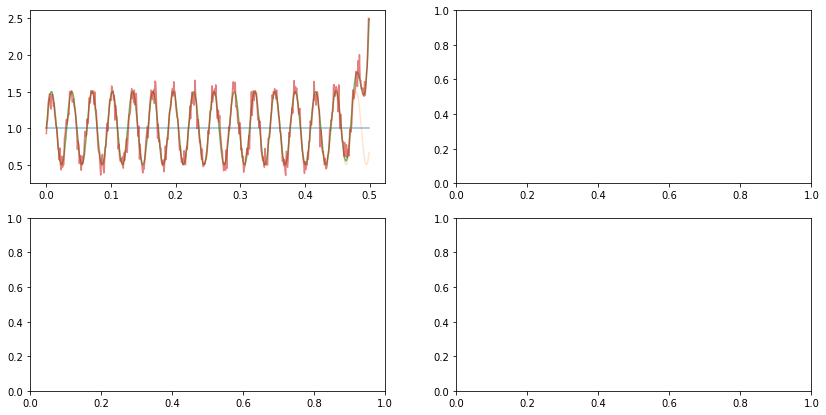

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,7))
ax = ax.flatten()

# input
ax[0].plot(t_arr, in_arr, label='constant', alpha=0.5)
ax[0].plot(t_arr, in_sine, label='constant+sine', alpha=0.2)
ax[0].plot(t_arr, in_sine_exp, label='constant+sine+exp', alpha=0.7)
ax[0].plot(t_arr, in_noisy_sine_exp, label='constant+sine+exp+noise', alpha=0.6)
ax[0].plot(t_arr_padded, padded_noisy_sine, label='constant+sine+exp+noise+padding', alpha=0.2)
ax[0].set_title('Input')
ax[0].set_xlabel('Time [ms]')
ax[0].legend()
ax[0].set_ylabel('Signal amplitude')
ax[0].set_ylim(-0.2,5)

ax[1].plot(freq_arr, np.abs(fft_arr), label='constant', alpha=0.5)
ax[1].plot(freq_arr, np.abs(fft_sine), label='constant+sine', alpha=0.2)
ax[1].plot(freq_arr, np.abs(fft_sine_exp), label='constant+sine+exp', alpha=0.7)
ax[1].plot(freq_arr, np.abs(fft_noisy_sine_exp), label='constant+sine+exp+noise', alpha=0.6)
ax[1].plot(freq_arr_padded, np.abs(fft_padded_noisy_sine_exp), label='constant+sine+exp+noise+padding', alpha=0.2)
ax[1].set_yscale('log')
ax[1].set_title('FFT')
ax[1].legend()
ax[1].set_xlabel('frequency [1/Hz]')
ax[1].set_ylabel('Absolute magnitude')
ax[1].set_ylim(0.0001,1000)

ax[2].plot(t_arr, noise_clip, label='Clipped noise signal', alpha=0.8, color='C2')
ax[2].plot(t_arr, in_noisy_sine_exp-noise_clip, label='Filtered signal', alpha=0.8, color='C1')
ax[2].set_xlim(-.1,0.6)
ax[2].set_ylim(-0.2,5)
ax[2].set_xlabel('Time [ms]')
ax[2].legend()
ax[2].set_ylabel('Signal amplitude')

ax[3].axvspan(xmin=lower, xmax=upper,color='C2', alpha=0.15, label='90% interval')
ax[3].hist(noise, bins=50, range=(plot_lower, plot_upper),normed=True)
xmin, xmax = ax[3].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax[3].plot(x, p, 'C1', linewidth=2, label=r"Fit results: $\mu$ = {0:.2g},  $\sigma$ = {1:.2f}".format(mu, std))
ax[3].legend()
ax[3].set_xlabel('Noise amplitude')
ax[3].set_ylabel('Entries per bin')
    
fig.tight_layout()
fig.savefig('fft_example.png', dpi=300)